## 1. Capture 2 seconds of my voice

In [1]:
# I checked my available devices with this code, and I found that my microphone
# has only one channel.

import sounddevice as sd
print(sd.query_devices())

# Import the necessary libraries
import sounddevice as sd
import numpy as np

  0 Micrófono de “Noah”, Core Audio (1 in, 0 out)
> 1 MacBook Pro (micrófono), Core Audio (1 in, 0 out)
< 2 MacBook Pro (altavoces), Core Audio (0 in, 2 out)
  3 Microsoft Teams Audio, Core Audio (2 in, 2 out)
  4 iShowU Audio Capture, Core Audio (2 in, 2 out)
  5 Dispositivo de salida múltiple, Core Audio (0 in, 2 out)


In [2]:
duration = 2  # seconds
fs = 44100  # sampling rate

print("Recording...")
voice = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float64')
sd.wait()
print("Recording complete!")

Recording...
Recording complete!


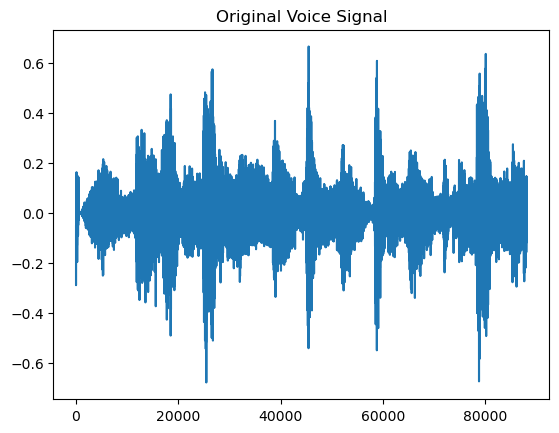

Playing original recording...
Playback complete.


In [3]:
import matplotlib.pyplot as plt
plt.plot(voice)
plt.title("Original Voice Signal")
plt.show()

print("Playing original recording...")
sd.play(voice, samplerate=fs)
sd.wait()
print("Playback complete.")

## 2. Filter the recording between 300 Hz and 4000 Hz

In [4]:
from scipy.signal import butter, lfilter

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = lfilter(b, a, data)
    return filtered_data

filtered_voice = bandpass_filter(voice, 300, 4000, fs)

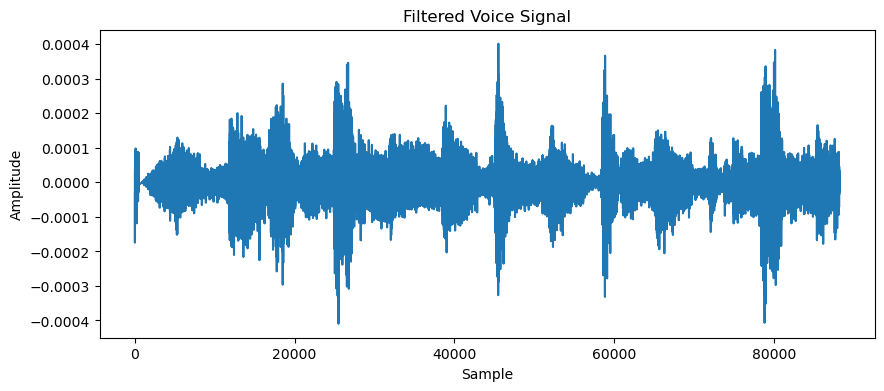

Playing original recording...
Playback complete.


In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(filtered_voice)
plt.title("Filtered Voice Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()


print("Playing original recording...")
amplified_voice = filtered_voice * 10000  # amplifying by a factor of 10000
sd.play(amplified_voice, samplerate=fs)
sd.wait()
print("Playback complete.")

## 3. Digitize it with Manchester encoding

In [6]:
def manchester_encode(signal):
    encoded = []
    for s in signal:
        if s > 0:
            encoded.extend([1, -1])
        else:
            encoded.extend([-1, 1])
    return np.array(encoded)

manchester_encoded = manchester_encode(filtered_voice)

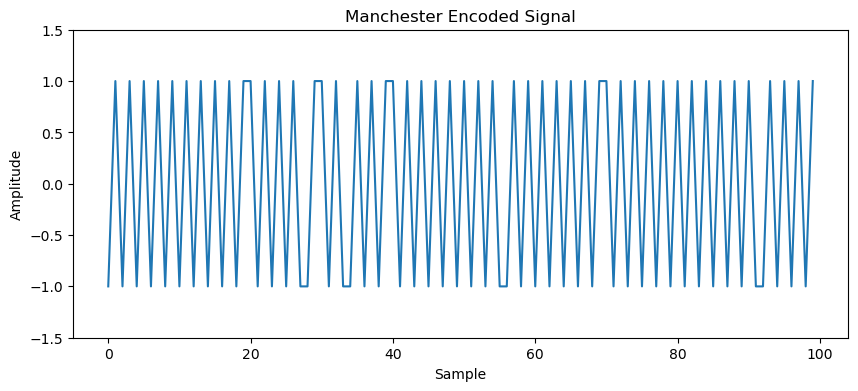

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(manchester_encoded[:100])  # Plotting the first 100 samples for clarity
plt.title("Manchester Encoded Signal")
plt.ylim(-1.5, 1.5)  # Set y-axis limits for better visualization
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

## 4. Modulate it in ASK with a carrier frequency of 100 KHz

In [8]:
def ask_modulation(data, carrier_freq, fs):
    t = np.arange(len(data)) / fs
    carrier = np.cos(2 * np.pi * carrier_freq * t)
    return data.ravel() * carrier

modulated_voice = ask_modulation(manchester_encoded, 100e3, fs)

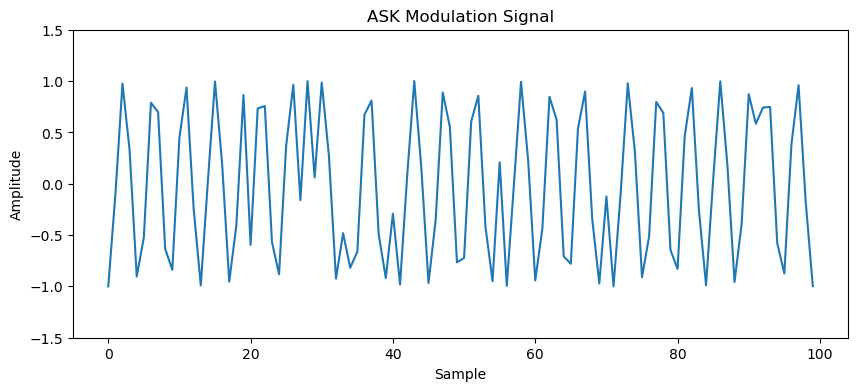

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(modulated_voice[:100])  # Plotting the first 100 samples for clarity
plt.title("ASK Modulation Signal")
plt.ylim(-1.5, 1.5)  # Set y-axis limits for better visualization
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

## 5. Reverse the process and play the recording

In [15]:
# Demodulate ASK
def ask_demodulation(data, carrier_freq, fs):
    t = np.arange(len(data)) / fs
    carrier = np.cos(2 * np.pi * carrier_freq * t)
    return data * carrier

print("Demodulating...")
demodulated_voice = ask_demodulation(modulated_voice, 100e3, fs)

# Manchester Decode
def manchester_decode(data):
    decoded = []
    for i in range(0, len(data), 2):
        if data[i] > data[i+1]:
            decoded.append(1)
        else:
            decoded.append(-1)
    return np.array(decoded)

print("Decoding...")
decoded_voice = manchester_decode(demodulated_voice)

# Low-pass filter to retrieve original voice signal
print("Filtering...")
decoded_voice = bandpass_filter(decoded_voice, 300, 4000, fs)

# Play the voice
sd.play(decoded_voice.astype(np.float32), samplerate=fs)
sd.wait()

Demodulating...
Decoding...
Filtering...


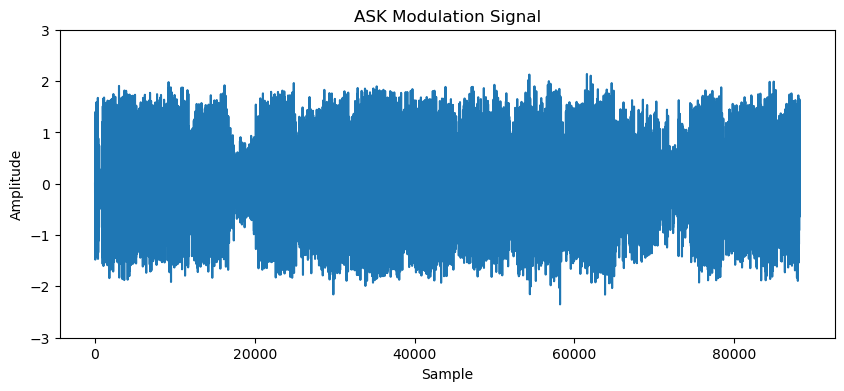

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(decoded_voice)  # Plotting the first 100 samples for clarity
plt.title("ASK Modulation Signal")
plt.ylim(-3, 3)  # Set y-axis limits for better visualization
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

**Malauradament, el filtering és inherentment un procés amb pèrdues. Un cop filtrat un senyal, la informació fora de la banda de pas (en aquest cas, fora de 300-4000 Hz) s'ha atenuat o eliminat. Per tant, no podem recuperar perfectament el senyal original del senyal filtrat.**